In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
rnd = 384

In [2]:
from exp.data import load_image_dataset, load_tabular_dataset

dataset_name = 'credit'

X_train, X_test, Y_train, Y_test, df_old, df  = load_tabular_dataset(dataset_name, './data/datasets/')

In [3]:
X_test.shape

(330, 59)

In [4]:
df_old

,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance,telephone,foreign_worker,account_check_status_0 <= ... < 200 DM,account_check_status_< 0 DM,account_check_status_>= 200 DM / salary assignments for at least 1 year,account_check_status_no checking account,credit_history_all credits at this bank paid back duly,credit_history_critical account/ other credits existing (not at this bank),credit_history_delay in paying off in the past,credit_history_existing credits paid back duly till now,credit_history_no credits taken/ all credits paid back duly,purpose_(vacation - does not exist?),purpose_business,purpose_car (new),purpose_car (used),purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/television,purpose_repairs,purpose_retraining,savings_.. >= 1000 DM,savings_... < 100 DM,savings_100 <= ... < 500 DM,savings_500 <= ... < 1000 DM,savings_unknown/ no savings account,present_emp_since_.. >= 7 years,present_emp_since_... < 1 year,present_emp_since_1 <= ... < 4 years,present_emp_since_4 <= ... < 7 years,present_emp_since_unemployed,personal_status_sex_female : divorced/separated/married,personal_status_sex_male : divorced/separated,personal_status_sex_male : married/widowed,personal_status_sex_male : single,other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,property_if not A121 : building society savings agreement/ life insurance,"property_if not A121/A122 : car or other, not in attribute 6",property_real estate,property_unknown / no property,other_installment_plans_bank,other_installment_plans_none,other_installment_plans_stores,housing_for free,housing_own,housing_rent,job_management/ self-employed/ highly qualified employee/ officer,job_skilled employee / official,job_unemployed/ unskilled - non-resident,job_unskilled - resident
0,-0.941176,-0.898867,1.000000,1.000000,0.714286,-0.333333,-1.0,1.0,1.0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
1,0.294118,-0.372620,-0.333333,-0.333333,-0.892857,-1.000000,-1.0,-1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
2,-0.764706,-0.796853,-0.333333,0.333333,0.071429,-1.000000,1.0,-1.0,1.0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1
3,0.117647,-0.160119,-0.333333,1.000000,-0.071429,-1.000000,1.0,-1.0,1.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0
4,-0.411765,-0.491581,0.333333,1.000000,0.214286,-0.333333,1.0,-1.0,1.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.764706,-0.836470,0.333333,1.000000,-0.571429,-1.000000,-1.0,-1.0,1.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1
996,-0.235294,-0.603059,1.000000,1.000000,-0.250000,-1.000000,-1.0,1.0,1.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0
997,-0.764706,-0.939034,1.000000,1.000000,-0.321429,-1.000000,-1.0,-1.0,1.0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0
998,0.205882,-0.824475,1.000000,1.000000,-0.857143,-1.000000,-1.0,1.0,1.0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0


In [5]:
import torch
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self, input_shape, latent_dim=2):
        super(LinearModel, self).__init__()

        # encoding components
        self.fc1 = nn.Linear(input_shape, latent_dim)

    def encode(self, x):
        x = self.fc1(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return z
    
latent_dim = 25
model = LinearModel(X_train.shape[1],latent_dim)

In [6]:
model.load_state_dict(torch.load(f'./models/{dataset_name}_LinearTransparent_latent_{latent_dim}.pt'))

<All keys matched successfully>

In [7]:
with torch.no_grad():
    Z_train = model(torch.tensor(X_train,dtype=torch.float32)).numpy()
    Z_test = model(torch.tensor(X_test,dtype=torch.float32)).numpy()

In [8]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=25)
neigh.fit(Z_train, Y_train)
KNN_pred = neigh.predict(Z_train)

In [9]:
neigh.score(Z_test,Y_test)

0.7333333333333333

In [10]:
from scipy.spatial import distance
import seaborn as sb
sb.set_style('whitegrid', rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":15,
                              "axes.titlepad":22, "axes.labelpad":18, "legend.fontsize":15, "legend.title_fontsize":15,
                              "font.family":'sans-serif'})
idx = 35

q = X_test[idx].reshape(1,-1).copy()
with torch.no_grad():
    z = model(torch.tensor(q,dtype=torch.float32)).numpy()

In [11]:
def predict(q):
    return neigh.predict(model(torch.tensor(q).float()).detach())

idx = 1
q = X_test[idx].reshape(1,-1).copy()
z = model(torch.tensor(q,dtype=torch.float32)).detach().numpy()
pred = int(predict(q))
pred

0

In [12]:
from scipy.spatial import distance

def find_changes(start_point, end_point=None, z_end=None, max_iter=5, debug=False):
    
    if z_end is None:
        z_end   = model(torch.tensor(end_point,dtype=torch.float32)).detach().numpy()
    z_start = model(torch.tensor(start_point,dtype=torch.float32)).detach().numpy()
    
    w = model.fc1.weight.detach().numpy()
    b = model.fc1.bias.detach().numpy()
    
    mods = np.zeros(len(start_point[0,:]))
    
    x_mod = start_point.copy()+mods
    z_mod = model(torch.tensor(x_mod).float()).detach().reshape(1,-1).numpy()

    pred = int(neigh.predict(z_start))
    pred_mod = int(neigh.predict(z_mod))
    j = 1
    dist = distance.euclidean(z_end,z_mod)
    
    while pred == pred_mod:
        if debug:
            print(distance.euclidean(z_end,z_mod))
        proj = z_end - z_mod
        d = np.argsort(np.abs(proj.dot(w)))
        d_mods = []
        for i in range(-start_point.shape[1],0):
            x_mod_prop = x_mod.copy()
            idx = d[0, i]
            mod = np.sum((z_end-(np.sum(x_mod[0,:idx]*w[:,:idx],axis=1)+np.sum(x_mod[0,idx+1:]*w[:,idx+1:],axis=1))-b)*w[:,idx])/(np.sum(w[:,idx]**2))
            if idx >= 5:
                mod = np.round(np.clip(mod,-1,1))
            else:
                mod = np.clip(mod,-1,1)
            x_mod_prop[0, idx] = mod
            z_mod_prop = model(torch.tensor(x_mod_prop).float()).detach().reshape(1,-1).numpy()
            d_mods.append(distance.euclidean(z_end,z_mod_prop))
        idx = d[0,range(-start_point.shape[1],0)[np.argmin(d_mods)]]
        mod = np.sum((z_end-(np.sum(x_mod[0,:idx]*w[:,:idx],axis=1)+np.sum(x_mod[0,idx+1:]*w[:,idx+1:],axis=1))-b)*w[:,idx])/(np.sum(w[:,idx]**2))
        if idx >= 5:
            mod = np.round(np.clip(mod,-1,1))
        else:
            mod = np.clip(mod,-1,1)
        mods[idx] += mod - x_mod[0,idx]
        x_mod[0, idx] = mod
        z_mod = model(torch.tensor(x_mod).float()).detach().reshape(1,-1).numpy()
        
        if distance.euclidean(z_end,z_mod) == dist:
            j +=1
        else:
            j = 1
            dist = distance.euclidean(z_end,z_mod)
        
        if j == max_iter:
            break
        
        pred_mod = int(neigh.predict(z_mod))
        if debug:
            print(pred,pred_mod)
            print(j)
        
    return mods

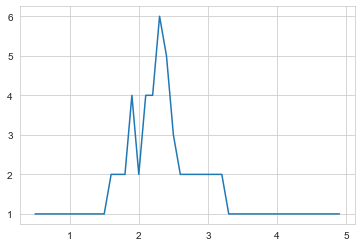

In [13]:
from sklearn.cluster import DBSCAN

n = []
for i in np.arange(0.5,5,0.1):
    clusters = DBSCAN(eps=i).fit(Z_train[Y_train==1-pred])    
    n.append(len(np.unique(clusters.labels_)))
plt.plot(np.arange(0.5,5,0.1),n)
eps = np.arange(0.5,5,0.1)[np.argmax(n)]

In [14]:
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist

clusters = DBSCAN(eps=eps).fit(Z_train[Y_train==1-pred])    
cs = []
print(np.unique(clusters.labels_))
for i in range(np.unique(clusters.labels_)[-1]):
    cs.append(np.mean(Z_train[Y_train==1-pred][clusters.labels_==i],axis=0))
c = cs[np.argmin(cdist(z,np.vstack(cs)))]
mods = find_changes(q, z_end=c, debug=True)


[-1  0  1  2  3  4]
3.010352373123169
0 0
1
2.2135889530181885
0 0
1
1.9505157470703125
0 0
1
1.7030376195907593
0 1
1


In [15]:
pd.DataFrame(np.vstack([q,mods]),columns=df_old.columns)

,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance,telephone,foreign_worker,account_check_status_0 <= ... < 200 DM,account_check_status_< 0 DM,account_check_status_>= 200 DM / salary assignments for at least 1 year,account_check_status_no checking account,credit_history_all credits at this bank paid back duly,credit_history_critical account/ other credits existing (not at this bank),credit_history_delay in paying off in the past,credit_history_existing credits paid back duly till now,credit_history_no credits taken/ all credits paid back duly,purpose_(vacation - does not exist?),purpose_business,purpose_car (new),purpose_car (used),purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/television,purpose_repairs,purpose_retraining,savings_.. >= 1000 DM,savings_... < 100 DM,savings_100 <= ... < 500 DM,savings_500 <= ... < 1000 DM,savings_unknown/ no savings account,present_emp_since_.. >= 7 years,present_emp_since_... < 1 year,present_emp_since_1 <= ... < 4 years,present_emp_since_4 <= ... < 7 years,present_emp_since_unemployed,personal_status_sex_female : divorced/separated/married,personal_status_sex_male : divorced/separated,personal_status_sex_male : married/widowed,personal_status_sex_male : single,other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,property_if not A121 : building society savings agreement/ life insurance,"property_if not A121/A122 : car or other, not in attribute 6",property_real estate,property_unknown / no property,other_installment_plans_bank,other_installment_plans_none,other_installment_plans_stores,housing_for free,housing_own,housing_rent,job_management/ self-employed/ highly qualified employee/ officer,job_skilled employee / official,job_unemployed/ unskilled - non-resident,job_unskilled - resident
0,-0.588235,-0.545505,0.333333,1.000000,-0.428571,-1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.000000,0.000000,0.000000,-1.125924,0.000000,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
from tqdm.notebook import tqdm

n = 100
if X_test.shape[0] < n:
    n = X_test.shape[0]

transp_cf = []
for i in tqdm(range(n)):
    q = X_test[i].reshape(1,-1).copy()
    with torch.no_grad():
        z = model(torch.tensor(q,dtype=torch.float32)).numpy()
    pred = int(predict(q))
    clusters = DBSCAN(eps=eps).fit(Z_train[Y_train==1-pred])    
    cs = []
    for i in range(np.unique(clusters.labels_)[-1]):
        cs.append(np.mean(Z_train[Y_train==1-pred][clusters.labels_==i],axis=0))
    c = cs[np.argmin(cdist(z,np.vstack(cs)))]
    transp_cf.append(find_changes(q, z_end=c, debug=False))

transp_cf = X_test[:n].copy()+np.vstack(transp_cf)

  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
from scipy.spatial.distance import cdist,euclidean

print('dis_dist:',np.mean(np.diag(cdist(transp_cf,X_test[:n].copy()))))
print('dis_count:', np.mean(np.mean(transp_cf!=X_test[:n].copy(),axis=1)))
print('impl:',np.mean(np.min(cdist(transp_cf,X_test),axis=1)))

dis_dist: 2.874729099851148
dis_count: 0.11830508474576272
impl: 2.5864415664827693


# Gradient descend Input space

In [18]:
def predict(q):
    return neigh.predict(model(torch.tensor(q).float()).detach())

In [19]:
idx = 0
q = X_test[idx].reshape(1,-1).copy()
pred = int(predict(q))
pred

0

In [20]:
mods = X_test[idx].reshape(1,-1).copy()
mods = torch.nn.parameter.Parameter(torch.tensor(mods, requires_grad=True).float())
loss = torch.nn.MSELoss()

In [21]:
centroid_0 = np.mean(Z_train[Y_train==0],axis=0)
centroid_1 = np.mean(Z_train[Y_train==1],axis=0)

if pred:
    loss(torch.tensor(centroid_0).reshape(1,-1),model(mods))
else:
    loss(torch.tensor(centroid_1).reshape(1,-1),model(mods))

In [22]:
opt = torch.optim.Adam([mods],lr=0.001)

In [23]:
from tqdm.notebook import tqdm
total_loss = []

while pred == 0:
    loss_epoch = loss(torch.tensor(centroid_1).reshape(1,-1),model(mods)) 
    total_loss.append(loss_epoch.item())
    loss_epoch.backward()
    opt.step()
    opt.zero_grad()
    pred = int(neigh.predict(model(mods).detach().numpy()))

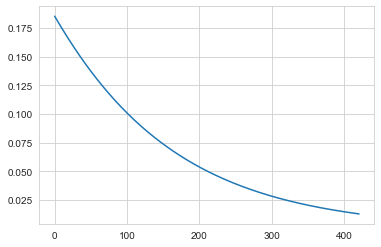

In [24]:
plt.plot(total_loss);

In [25]:
grad_cf = []
not_found = []
for i in tqdm(range(n)):
    q = X_test[i].reshape(1,-1).copy()
    loss = torch.nn.MSELoss()
    with torch.no_grad():
        z = model(torch.tensor(q,dtype=torch.float32)).numpy()
    pred = int(neigh.predict(z))
    q = torch.nn.parameter.Parameter(torch.tensor(q, requires_grad=True).float())
    opt = torch.optim.Adam([q],lr=0.001)
    if pred==1:
        centroid = centroid_0
    else:
        centroid = centroid_1
    total_loss = []    
    nf = 0
    while pred == int(neigh.predict(z)):
        loss_epoch = loss(torch.tensor(centroid).reshape(1,-1),model(q)) 
        total_loss.append(loss_epoch.item())
        loss_epoch.backward()
        opt.step()
        opt.zero_grad()
        pred = int(neigh.predict(model(q).detach().numpy()))
        if loss_epoch.item()<1e-10:
            break
            nf = 1
    if nf:
        not_found.append(i)
    else:
        grad_cf.append(q.detach().numpy().ravel())

  0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
from scipy.spatial.distance import cdist,euclidean

print('dis_dist:',np.mean(np.diag(cdist(grad_cf,X_test[:n].copy()))))
print('dis_count:', np.mean(np.mean(grad_cf!=X_test[:n].copy(),axis=1)))
print('impl:',np.mean(np.min(cdist(grad_cf,X_test),axis=1)))

dis_dist: 2.6568648577447984
dis_count: 1.0
impl: 2.6473338638076593


# Growing Spheres

In [27]:
from growingspheres import counterfactuals as cf

idx = 0
def predict(q):
    return neigh.predict(model(torch.tensor(q).float()).detach())

q = X_test[idx].reshape(1,-1).copy()
pred = int(predict(q))
pred

0

In [28]:
CF = cf.CounterfactualExplanation(q, predict, method='GS')
CF.fit(n_in_layer=2000, first_radius=0.1, dicrease_radius=10, sparse=True, verbose=True)
q_cf = CF.enemy

0 ennemies found in initial sphere. Zooming in...
Exploring...
Final number of iterations:  60
Final radius:  (1.0720000000000005, 1.0900000000000005)
Final number of ennemies:  1
Feature selection...
Reduced 25 coordinates


In [29]:
predict(q_cf.reshape(1,-1))

array([1])

In [30]:
from tqdm.notebook import tqdm
import time
import signal

class timeout:
    def __init__(self, seconds=1, error_message='Timeout'):
        self.seconds = seconds
        self.error_message = error_message
    def handle_timeout(self, signum, frame):
        raise Exception('timeout')
    def __enter__(self):
        signal.signal(signal.SIGALRM, self.handle_timeout)
        signal.alarm(self.seconds)
    def __exit__(self, type, value, traceback):
        signal.alarm(0)

def fit_GS(q, predict):
    CF = cf.CounterfactualExplanation(q, predict, method='GS')
    try:
        with timeout(seconds=60):
            CF.fit(n_in_layer=2000, first_radius=0.1, dicrease_radius=10, sparse=True, verbose=False)
        return CF
    except:
        CF.enemy = np.nan
        return CF
        
gs_cf = []
not_found = []
for i in tqdm(range(n)):
    start = time.time()
    q = X_test[i].reshape(1,-1).copy()
    CF = fit_GS(q,predict)
    if CF.enemy is np.nan:
        not_found.append(i)
    else:
        gs_cf.append(CF.enemy)
gs_cf = np.vstack(gs_cf)

  0%|          | 0/100 [00:00<?, ?it/s]

In [31]:
from scipy.spatial.distance import cdist,euclidean

print('dis_dist:',np.mean(np.diag(cdist(gs_cf,X_test[:n].copy()))))
print('dis_count:', np.mean(np.mean(gs_cf[:n]!=X_test[:n].copy(),axis=1)))
print('impl:',np.mean(np.min(cdist(gs_cf,X_test),axis=1)))

dis_dist: 1.2240550631475602
dis_count: 0.3467796610169493
impl: 1.21899494777418


In [32]:
transparent_height=np.sum(transp_cf!=X_test[:n].copy(),axis=0)
gd_height=np.sum(grad_cf!=X_test[:n].copy(),axis=0)
gsg_height=np.sum(gs_cf!=X_test[:n].copy(),axis=0)

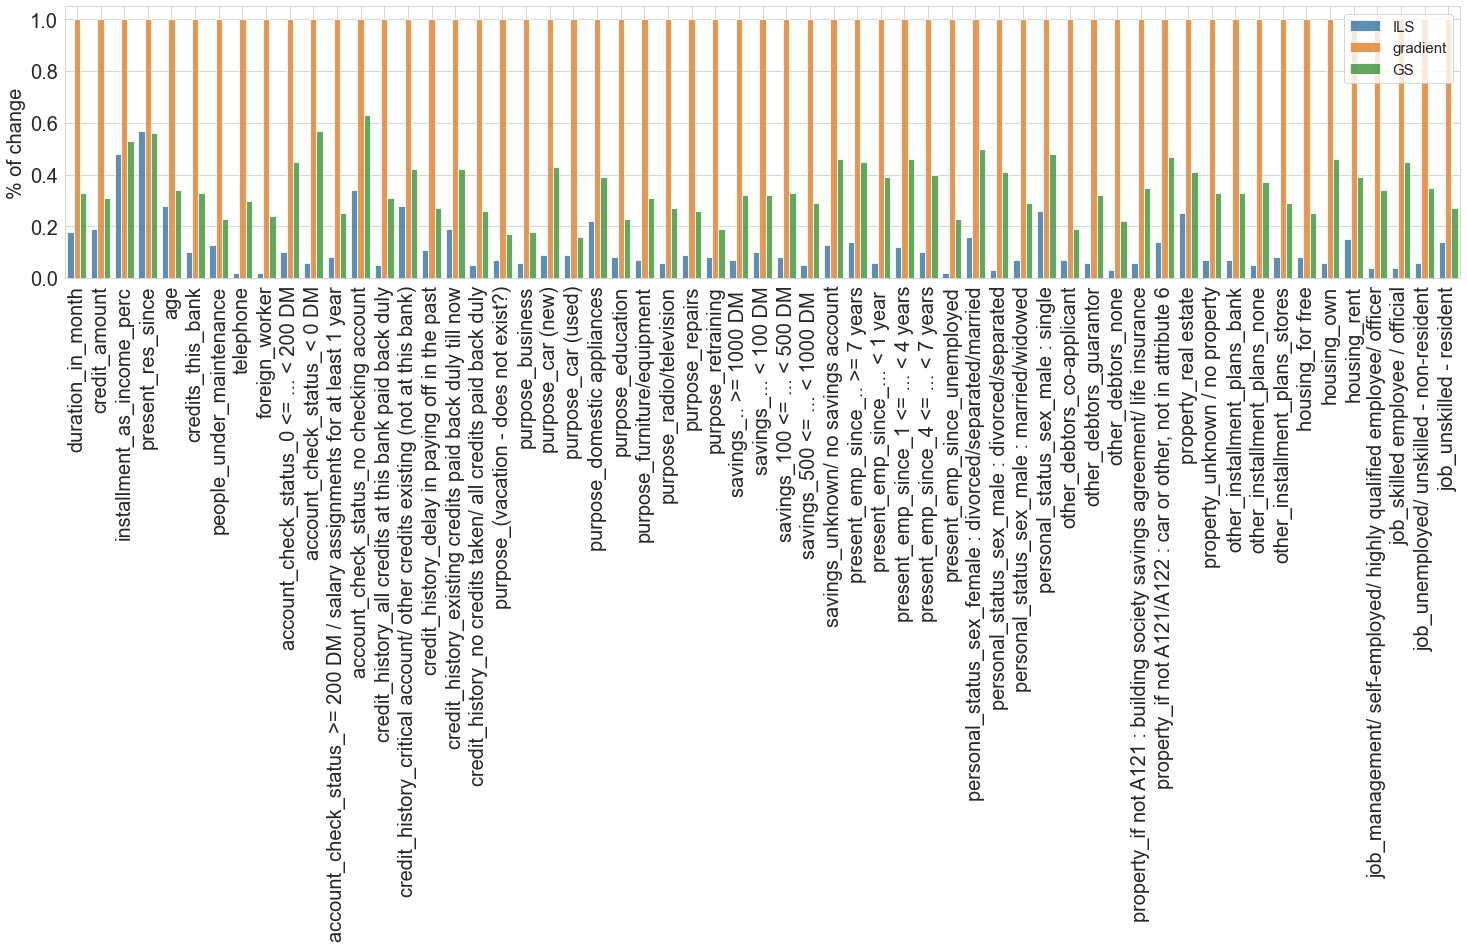

In [33]:
dataf = pd.DataFrame(np.vstack((transparent_height,gd_height,gsg_height))/n,columns=df_old.columns)
dataf = dataf.transpose().melt(ignore_index=False)
d = {0 : 'ILS', 1 : 'gradient', 2 : 'GS'}
dataf.replace({"variable": d}, inplace=True)
plt.figure(figsize=(25,5))
sb.barplot(hue=dataf['variable'],y=dataf['value'],x=dataf.index,alpha=0.8)
plt.grid(True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('% of change',fontsize=20)
plt.legend(fontsize=15)
plt.xticks(rotation=90)
plt.savefig(f'./figures/{dataset_name}_distribution_of_mods.pdf',bbox_inches='tight')
